## Introduction 
In the previous post, we saw how to do Image Classification by performing crop of the central part of an image and making an inference using one of the standart classification models. After that, we saw how to perform the network inference on the whole image by changing the network to fully convolutional one. This approach gave us a downsampled prediction map for the image -- that happened due to the fact that max-pooling layers are used in the network architecture. This prediction map can be treated as an efficient way to make an inference of the network for the whole image. You can also think about it as a way to make Image Segmentation, but it is not an actual Segmentation, because the standart network models were trained to perform Classification. To make it perform an actual Segmentation, we will have to train it on Segmentation dataset in a special way like in the paper Fully convolutional networks for semantic segmentation by Long et al. Two of the most popular general Segmentation datasets are: Microsoft COCO and PASCAL VOC.

In this post, we will perform image upsampling to get the prediction map that is of the same size as an input image. We will do this using transposed convolution (also known as deconvolution). It is recommended not to use the deconvolution name for this operation as it can be confused with another operation and it does not represent accurately the actual process that is being performed. The most accurate name for the kind of operation that we will perform in this post is fractionally strided convolution. We will cover a small part of theory necessary for understanding and some resources will be cited.

One question might be raised up now: Why do we need to perform upsampling using fractionally strided convolution? Why can't we just use some library to do this for us? The answer is: we need to do this because we need to define the upsampling operation as a layer in the network. And why do we need it as a layer? Because we will have to perform training where the image and respective Segmentation groundtruth will be given to us -- and we will have to perform training using backpropagation. As it is known , each layer in the network has to be able to perform three operations: forward propagation, backward propagation and update which performs updates to the weights of the layer during training. By doing the upsampling with transposed convolution we will have all of these operations defined and we will be able to perform training.

By the end of the post, we will implement the upsampling and will make sure it is correct by comparing it to the implementation of the scikit-image library. To be more specific we will have FCN-32 Segmentation network implemented which is described in the paper Fully convolutional networks for semantic segmentation. To perform the training, the loss function has to be defined and training dataset provided.

In [1]:
import tensorflow as tf
import numpy as np 
import tensorflow.contrib.slim as slim
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/home/ubuntu/workspace/models/slim")
from datasets import dataset_utils
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = './checkpoints'

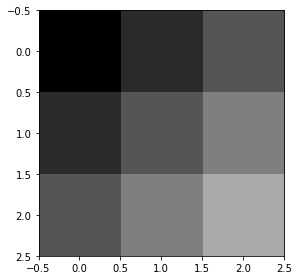

In [3]:
from numpy import ogrid, repeat, newaxis
from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

In [14]:
img.shape

(3, 3, 3)

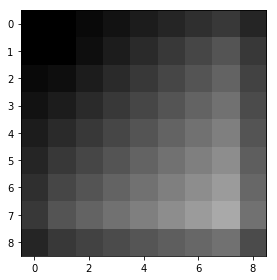

In [15]:
import skimage.transform

def upsample_skimage(factor, input_img):    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

In [16]:
upsampled_img_skimage.shape

(9, 9, 3)